# Analyze the effect of nonlinearity
This notebook is still a bit messy :)

In [1]:
import itertools
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-toy'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset
from train import train
from nn_models import MLP
from hnn import HNN, HNNBaseline
from utils import L2_loss

## Set some notebook constants

In [19]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 250,
         'print_every': 150,
         'name': 'toy',
         'input_noise': 0.0,
         'gridsize': 10,
         'baseline': False,
         'verbose': False,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Train models

In [7]:
random_seed = np.arange(250) # 60 different weight initializations / datasets
activations = ['tanh', 'sigmoid', 'selu', 'relu'] # four different activations
hnn_models, base_models = [], []

hypers = list(itertools.product(random_seed, activations))
rand_learn_rates = 10**(np.random.rand(len(hypers))*4.5-4.5) # different learning rates for all 240 trials

for i, (seed, nonlin) in enumerate(hypers):
    
    lr = rand_learn_rates[i] # actually, sample learning rate randomly
    
    arg_dict = get_args()
    arg_dict['learn_rate'] = lr
    arg_dict['nonlinearity'] = nonlin
    arg_dict['seed'] = seed
    
    args = ObjectView(arg_dict)
    hnn_model, stats = train(args)
    hnn_models += [ {'stats': stats, 'lr': lr, 'nonlin': nonlin} ]
    del hnn_model
    
    args.baseline = True
    base_model, stats = train(args)
    base_models += [ {'stats': stats, 'lr': lr, 'nonlin': nonlin} ]
    del base_model
    
    print("{}/{} ({:.1f}% done)".format(i, len(hypers), 100*float(i)/len(hypers)), end='\r')

## Plot LR vs lowest validation loss

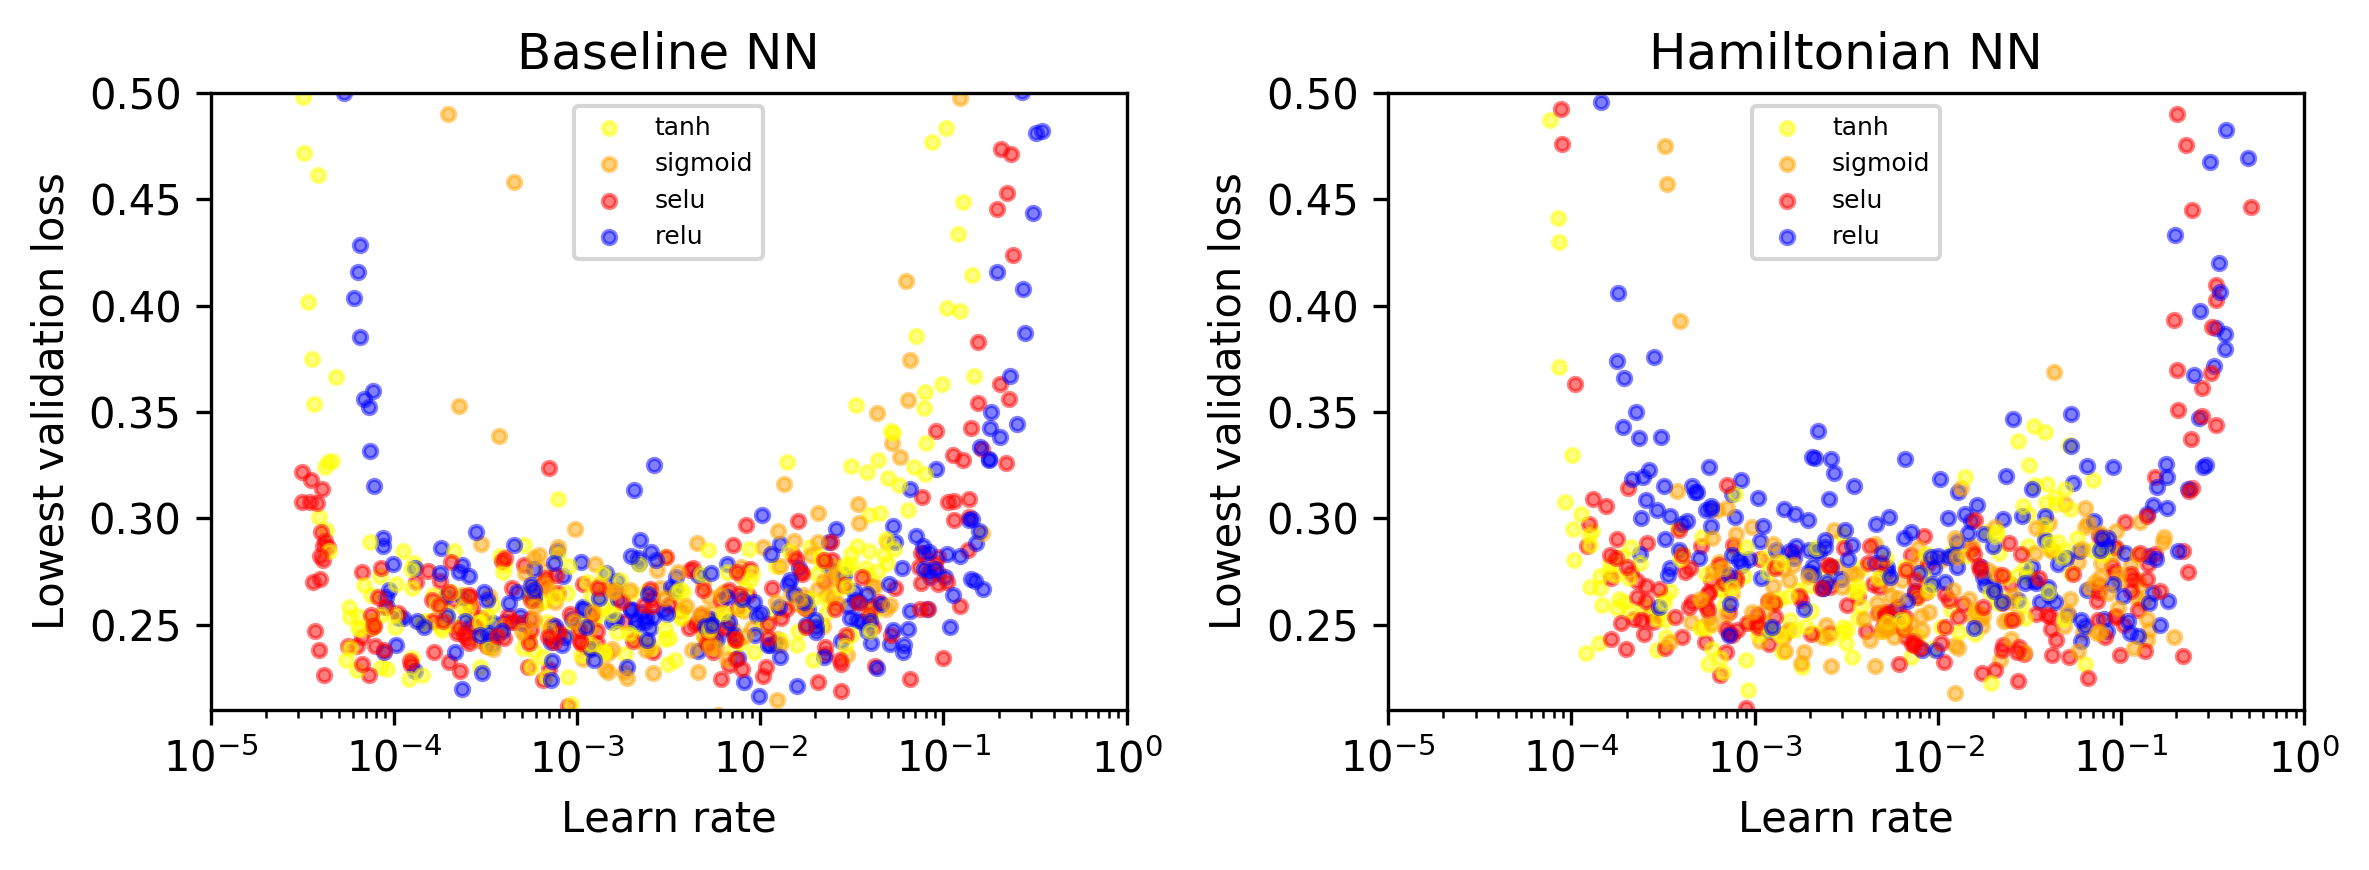

In [20]:
ymin, ymax = 0.21, 0.5
max_step = -1
colors = {activations[i] : c for i, c in enumerate(['yellow', 'orange', 'red', 'blue'])}
markersize = 10

fig = plt.figure(figsize=(8, 3), facecolor='white', dpi=DPI)

ax = fig.add_subplot(1, 2, 1, frameon=True)
for i, model in enumerate(base_models):
    label = model['nonlin'] if i < len(activations) else None
    x = model['lr']
    y = np.min( model['stats']['val_loss'] )
    ax.scatter(x, y, color=colors[model['nonlin']], s=markersize, label=label, alpha=0.5)
ax.set_ylabel('Lowest validation loss') ; ax.set_xlabel('Learn rate')
ax.set_title('Baseline NN')
ax.set_ylim(ymin, ymax) ; ax.set_xlim(1e-5, 1e0)
ax.set_xscale('log')
plt.legend(fontsize=6, loc='upper center')

ax = fig.add_subplot(1, 2, 2, frameon=True)
for i, model in enumerate(hnn_models):
    label = model['nonlin'] if i < len(activations) else None
    x = model['lr']
    y = np.min( model['stats']['val_loss'] )
    ax.scatter(x, y, color=colors[model['nonlin']], s=markersize, label=label, alpha=0.5)
ax.set_ylabel('Lowest validation loss') ; ax.set_xlabel('Learn rate')
ax.set_title('Hamiltonian NN')
ax.set_ylim(ymin, ymax) ; ax.set_xlim(1e-5, 1e0)
ax.set_xscale('log')
plt.legend(fontsize=6, loc='upper center')

plt.tight_layout() ; plt.show()
fig.savefig('{}/nonlinearity-adam.{}'.format(args.fig_dir, FORMAT))

## Zoom out

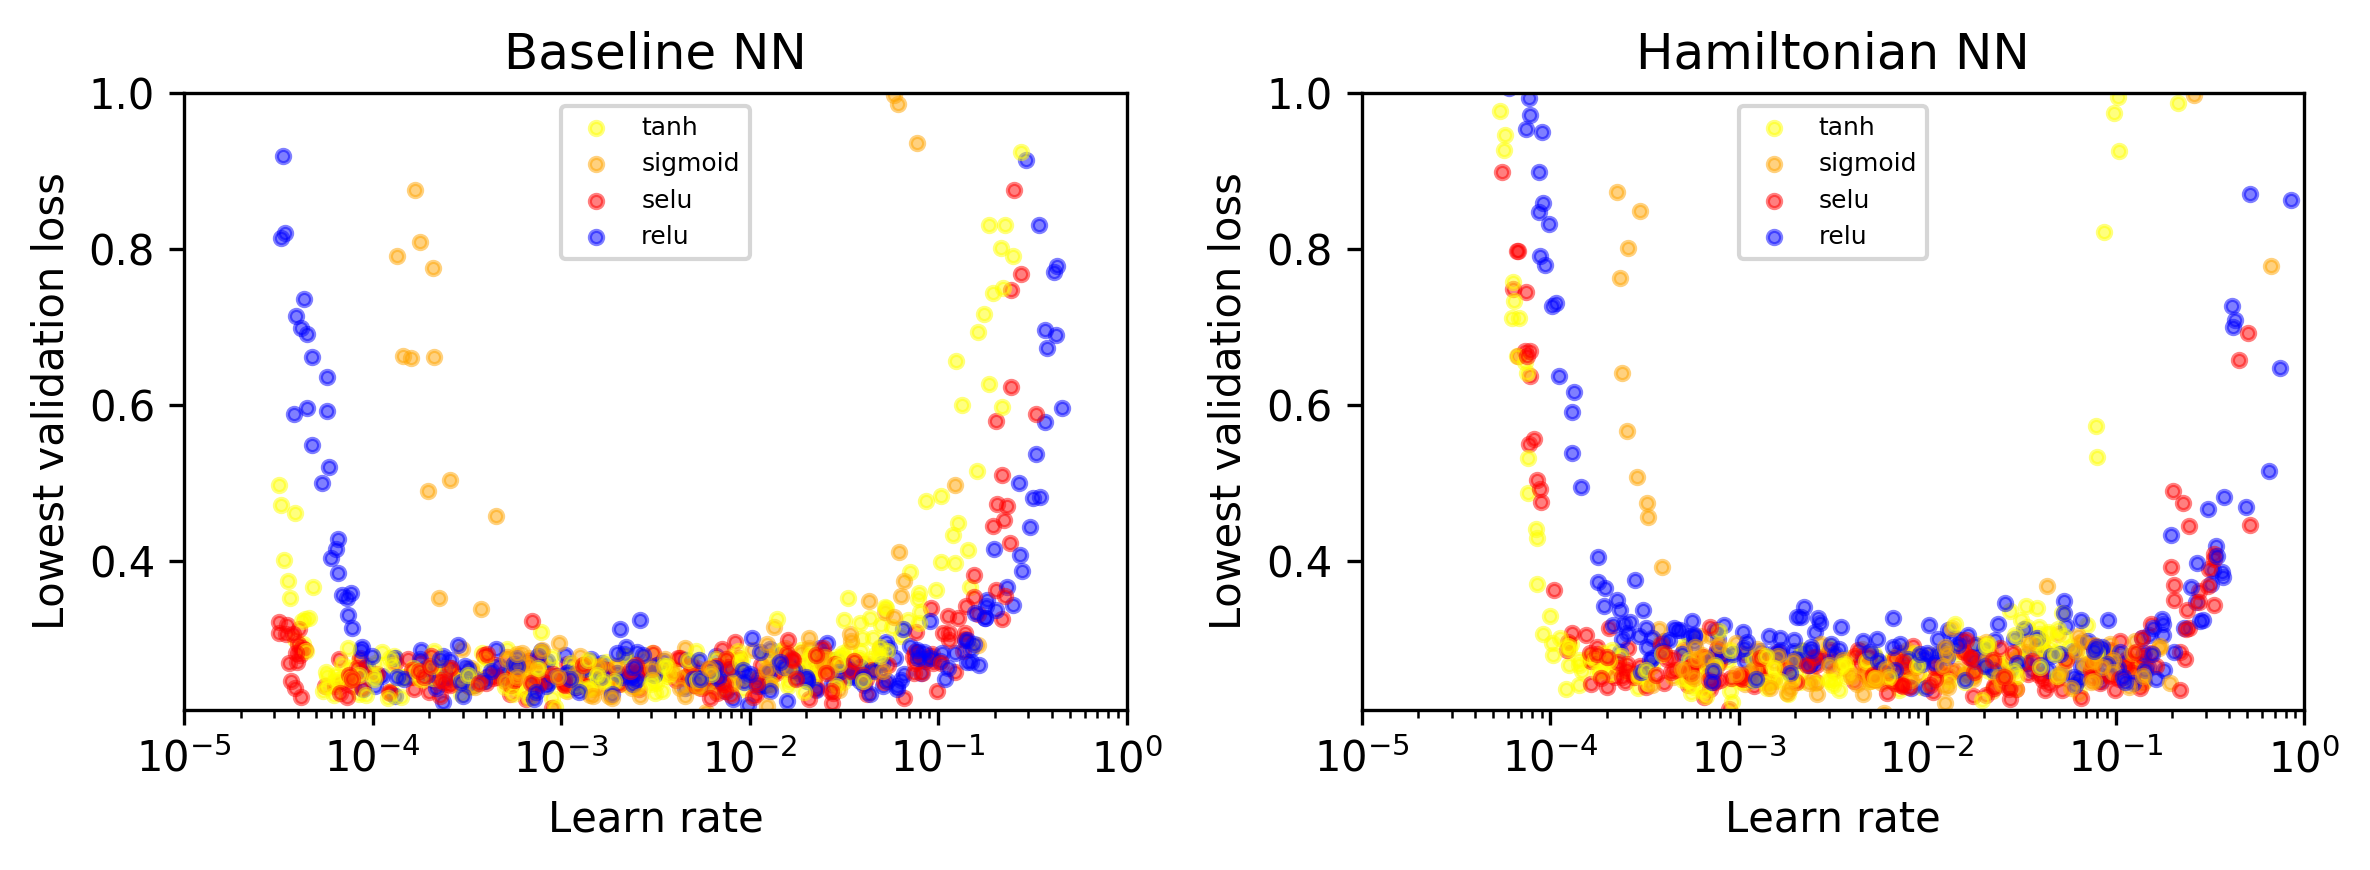

In [21]:
ymin, ymax = 0.21, 1
max_step = -1
colors = {activations[i] : c for i, c in enumerate(['yellow', 'orange', 'red', 'blue'])}
markersize = 10

fig = plt.figure(figsize=(8, 3), facecolor='white', dpi=DPI)

ax = fig.add_subplot(1, 2, 1, frameon=True)
for i, model in enumerate(base_models):
    label = model['nonlin'] if i < len(activations) else None
    x = model['lr']
    y = np.min( model['stats']['val_loss'] )
    ax.scatter(x, y, color=colors[model['nonlin']], s=markersize, label=label, alpha=0.5)
ax.set_ylabel('Lowest validation loss') ; ax.set_xlabel('Learn rate')
ax.set_title('Baseline NN')
ax.set_ylim(ymin, ymax) ; ax.set_xlim(1e-5, 1e0)
ax.set_xscale('log')
plt.legend(fontsize=6, loc='upper center')

ax = fig.add_subplot(1, 2, 2, frameon=True)
for i, model in enumerate(hnn_models):
    label = model['nonlin'] if i < len(activations) else None
    x = model['lr']
    y = np.min( model['stats']['val_loss'] )
    ax.scatter(x, y, color=colors[model['nonlin']], s=markersize, label=label, alpha=0.5)
ax.set_ylabel('Lowest validation loss') ; ax.set_xlabel('Learn rate')
ax.set_title('Hamiltonian NN')
ax.set_ylim(ymin, ymax) ; ax.set_xlim(1e-5, 1e0)
ax.set_xscale('log')
plt.legend(fontsize=6, loc='upper center')

plt.tight_layout() ; plt.show()
fig.savefig('{}/nonlinearity-adam-zoomout.{}'.format(args.fig_dir, FORMAT))

## Plot LR vs final validation loss

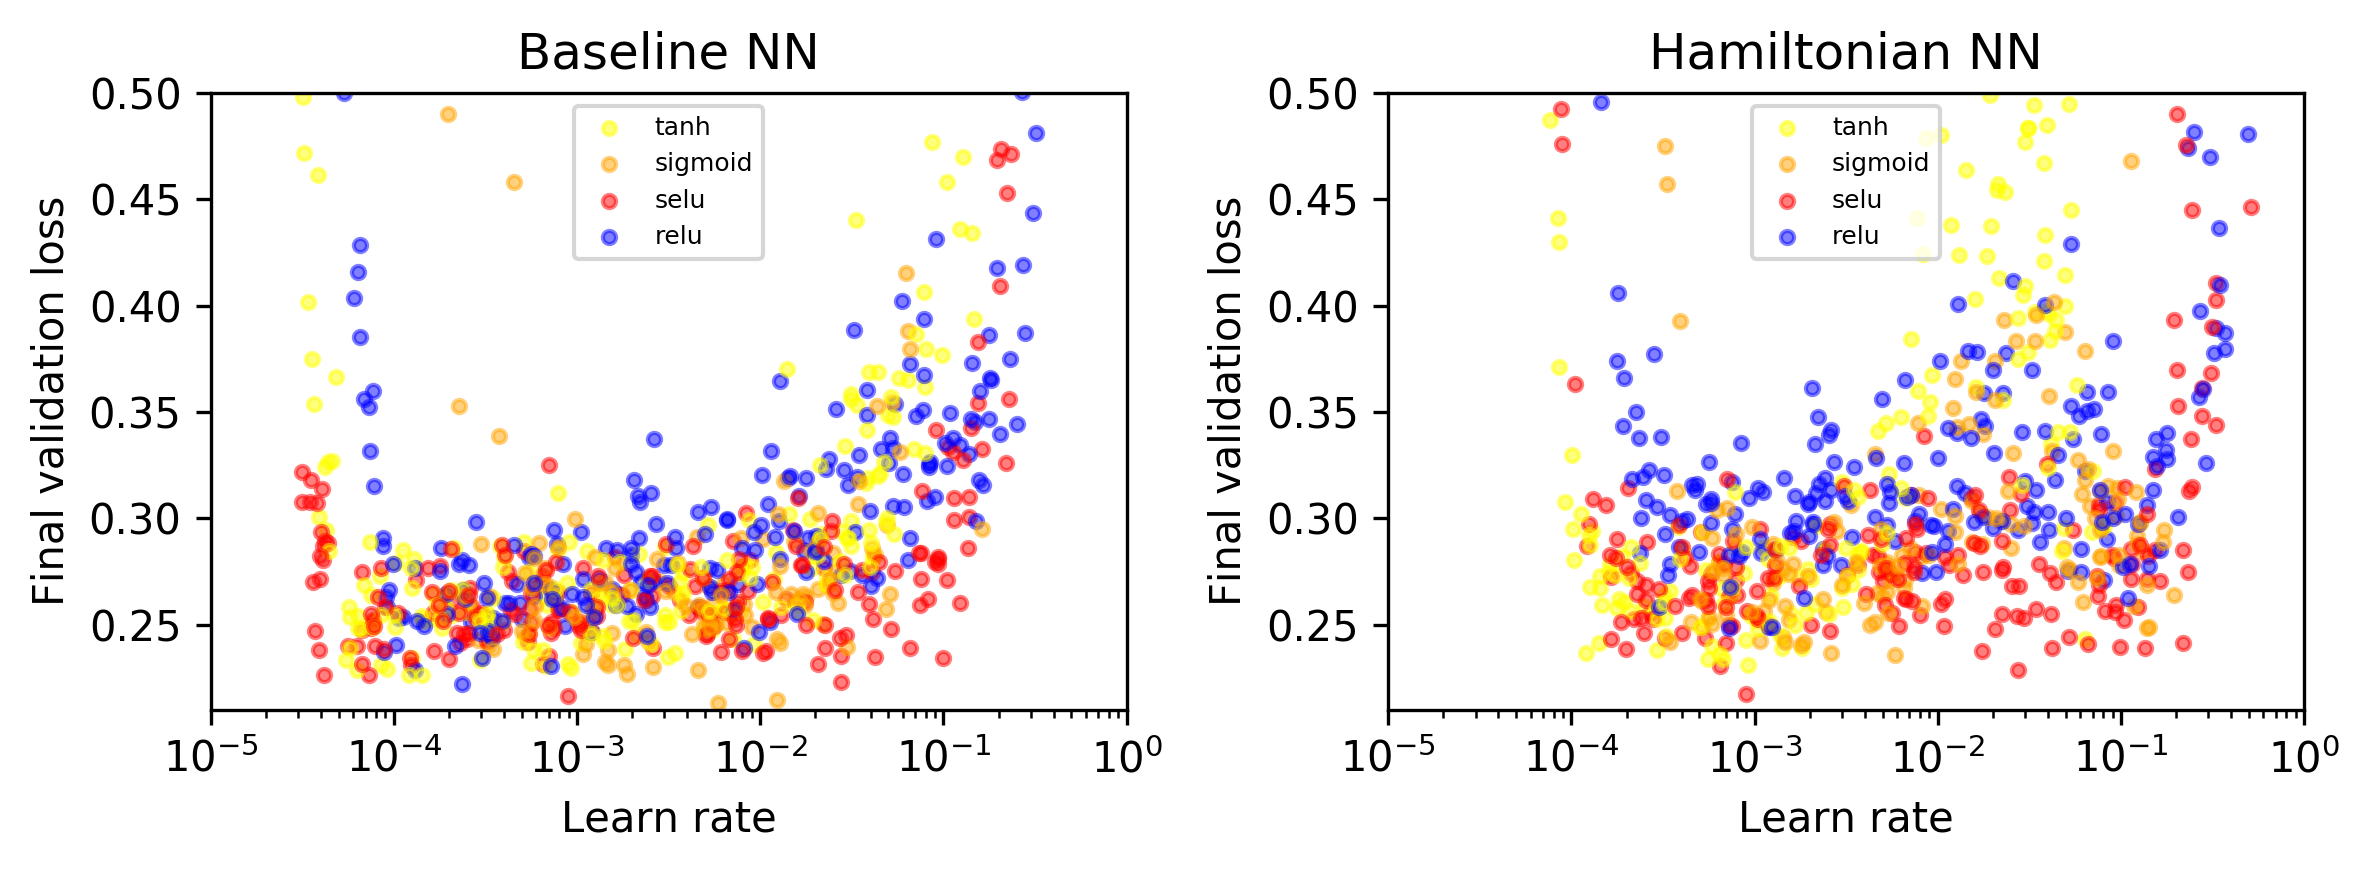

In [ ]:
ymin, ymax = 0.21, 0.5
max_step = -1
colors = {activations[i] : c for i, c in enumerate(['yellow', 'orange', 'red', 'blue'])}
markersize = 10

fig = plt.figure(figsize=(8, 3), facecolor='white', dpi=DPI)

ax = fig.add_subplot(1, 2, 1, frameon=True)
for i, model in enumerate(base_models):
    label = model['nonlin'] if i < len(activations) else None
    x = model['lr']
    y = model['stats']['val_loss'][-1]
    ax.scatter(x, y, color=colors[model['nonlin']], s=markersize, label=label, alpha=0.5)
ax.set_ylabel('Final validation loss') ; ax.set_xlabel('Learn rate')
ax.set_title('Baseline NN')
ax.set_ylim(ymin, ymax) ; ax.set_xlim(1e-5, 1e0)
ax.set_xscale('log')
plt.legend(fontsize=6, loc='upper center')

ax = fig.add_subplot(1, 2, 2, frameon=True)
for i, model in enumerate(hnn_models):
    label = model['nonlin'] if i < len(activations) else None
    x = model['lr']
    y = model['stats']['val_loss'][-1]
    ax.scatter(x, y, color=colors[model['nonlin']], s=markersize, label=label, alpha=0.5)
ax.set_ylabel('Final validation loss') ; ax.set_xlabel('Learn rate')
ax.set_title('Hamiltonian NN')
ax.set_ylim(ymin, ymax) ; ax.set_xlim(1e-5, 1e0)
ax.set_xscale('log')
plt.legend(fontsize=6, loc='upper center')

plt.tight_layout() ; plt.show()
fig.savefig('{}/nonlinearity-adam-final.{}'.format(args.fig_dir, FORMAT))

## Zoom out

In [ ]:
ymin, ymax = 0.21, 1
max_step = -1
colors = {activations[i] : c for i, c in enumerate(['yellow', 'orange', 'red', 'blue'])}
markersize = 10

fig = plt.figure(figsize=(8, 3), facecolor='white', dpi=DPI)

ax = fig.add_subplot(1, 2, 1, frameon=True)
for i, model in enumerate(base_models):
    label = model['nonlin'] if i < len(activations) else None
    x = model['lr']
    y = model['stats']['val_loss'][-1]
    ax.scatter(x, y, color=colors[model['nonlin']], s=markersize, label=label, alpha=0.5)
ax.set_ylabel('Final validation loss') ; ax.set_xlabel('Learn rate')
ax.set_title('Baseline NN')
ax.set_ylim(ymin, ymax) ; ax.set_xlim(1e-5, 1e0)
ax.set_xscale('log')
plt.legend(fontsize=6, loc='upper center')

ax = fig.add_subplot(1, 2, 2, frameon=True)
for i, model in enumerate(hnn_models):
    label = model['nonlin'] if i < len(activations) else None
    x = model['lr']
    y = model['stats']['val_loss'][-1]
    ax.scatter(x, y, color=colors[model['nonlin']], s=markersize, label=label, alpha=0.5)
ax.set_ylabel('Final validation loss') ; ax.set_xlabel('Learn rate')
ax.set_title('Hamiltonian NN')
ax.set_ylim(ymin, ymax) ; ax.set_xlim(1e-5, 1e0)
ax.set_xscale('log')
plt.legend(fontsize=6, loc='upper center')

plt.tight_layout() ; plt.show()
fig.savefig('{}/nonlinearity-adam-final-zoomout.{}'.format(args.fig_dir, FORMAT))